In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malware-classification-final-csv/final_data.csv


In [2]:
import pandas as pd

image_feat = pd.read_csv('/kaggle/input/malware-classification-final-csv/final_data.csv')

In [3]:
y = image_feat['Class']
image_feat = image_feat.drop(columns=['Id', 'Class'])

In [4]:
def imp_features(data, features, keep, result_y):
    rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
    rf.fit(data, result_y)
    imp_feature_indx = np.argsort(rf.feature_importances_)[::-1]
    imp_value = np.take(rf.feature_importances_, imp_feature_indx[:20])
    imp_feature_name = np.take(features, imp_feature_indx[:20])
    sns.set()
    plt.figure(figsize = (10, 5))
    ax = sns.barplot(x = imp_feature_name, y = imp_value)
    ax.set_xticklabels(labels = imp_feature_name, rotation = 45)
    sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
    plt.title('Important Features')
    plt.xlabel('Feature Names')
    plt.ylabel('Importance')
    return imp_feature_indx[:keep]

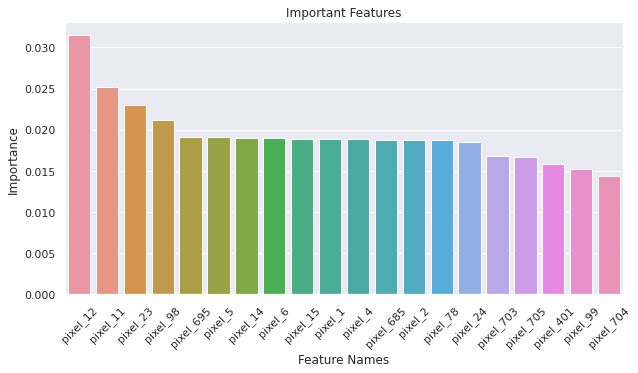

In [7]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

indices = imp_features(image_features, list(image_features.columns), 400, y)

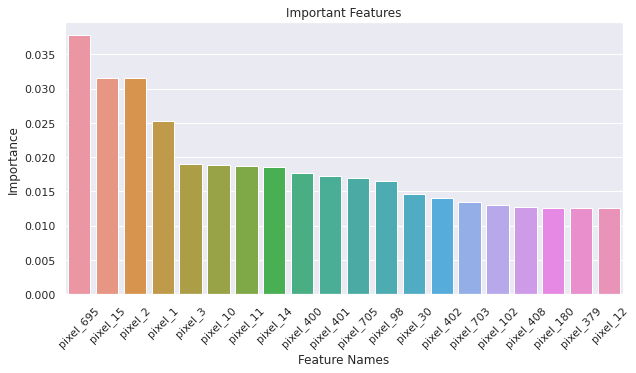

In [52]:
indices = imp_features(image_features, list(image_features.columns), 1000, y)

imp_col = np.take(list(image_features.columns), indices)

df1= image_features[imp_col.tolist()]

In [56]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(image_feat, y, test_size=0.20, stratify=y, random_state=1)
xtrain, xcv, ytrain, ycv = train_test_split(xtrain, ytrain, test_size=0.20, stratify=ytrain, random_state=1)

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

## METRICS - LOGLOSS

In [58]:
x_cfl=XGBClassifier(n_estimators=2000, random_state=2021, tree_method='gpu_hist')

x_cfl.fit(xtrain,ytrain,verbose=True)

sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")

sig_clf.fit(xtrain, ytrain)

predict_y = sig_clf.predict_proba(xtrain)
print ('For values of best alpha = ', 100, "The train log loss is:",log_loss(ytrain, predict_y))

predict_y = sig_clf.predict_proba(xcv)
print('For values of best alpha = ', 100, "The cross validation log loss is:",log_loss(ycv, predict_y))

predict_y = sig_clf.predict_proba(xtest)
print('For values of best alpha = ', 100, "The test log loss is:",log_loss(ytest, predict_y))

For values of best alpha =  100 The train log loss is: 0.018836907534576865
For values of best alpha =  100 The cross validation log loss is: 0.029597063871003585
For values of best alpha =  100 The test log loss is: 0.017579188757934187


In [ ]:
predict_y

In [59]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

## CONFUSION - MATRIX

Number of misclassified points  0.09199632014719411
-------------------------------------------------- Confusion matrix --------------------------------------------------


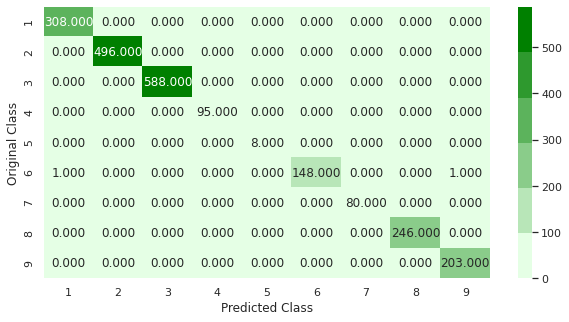

-------------------------------------------------- Precision matrix --------------------------------------------------


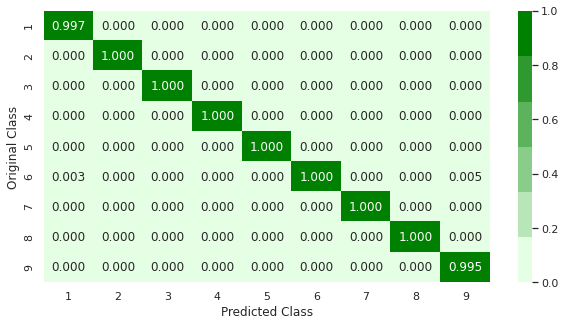

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


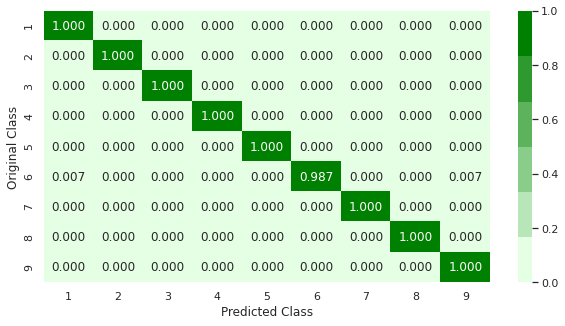

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [62]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(ytest, sig_clf.predict(xtest))

## PROCEDURE :

```

> 1.First I took the byte file and made Exploratory Data Analysis.
 
> 2.used uni-gram count features and applied machine learning models.

> 3.preprocessed the asm file and extracted various segment count as features.
 
> 4.applied machine learning models on asm segment count.
 
> 5.combined byte features and asm segment features.
 
> 6.applied machine learning models on combined features.

> 7.extracted features like byte bigram,opcode bi gram,opcode trigram ,  opcode tetra gram and 800 pixels of asm image.
 
> 8.appplied machine learning models on combined features.

```

## RESULT:

In [63]:
from prettytable import PrettyTable

ptable = PrettyTable()

ptable.title = " Model Comparision "
ptable.field_names = ["Model",'Features','log loss']

ptable.add_row(["random","Byte files","2.45"])
ptable.add_row(["knn","Byte files","0.48"])
ptable.add_row(["Logistic Regression","Byte files","0.52"])
ptable.add_row(["Random Forest Classifier ","Byte files","0.06"])
ptable.add_row(["XgBoost Classification","Byte files","0.07"])
ptable.add_row(["\n","\n","\n"])
ptable.add_row(["knn","asmfiles","0.21"])
ptable.add_row(["Logistic Regression","asmfiles","0.38"])
ptable.add_row(["Random Forest Classifier ","asmfiles","0.03"])
ptable.add_row(["XgBoost Classification","asmfiles","0.04"])
ptable.add_row(["\n","\n","\n"])
ptable.add_row(["Random Forest Classifier ","Byte files+asmfiles","0.04"])
ptable.add_row(["XgBoost Classification","Byte files+asmfiles","0.02"])
ptable.add_row(["\n","\n","\n"])
ptable.add_row(["Logistic Regression","Byte files+asmfiles+advanced features","1.12"])
ptable.add_row(["XgBoost Classification","Byte files+asmfiles+advanced features","0.01"])
print(ptable)

+---------------------------+---------------------------------------+----------+
|           Model           |                Features               | log loss |
+---------------------------+---------------------------------------+----------+
|           random          |               Byte files              |   2.45   |
|            knn            |               Byte files              |   0.48   |
|    Logistic Regression    |               Byte files              |   0.52   |
| Random Forest Classifier  |               Byte files              |   0.06   |
|   XgBoost Classification  |               Byte files              |   0.07   |
|                           |                                       |          |
|                           |                                       |          |
|            knn            |                asmfiles               |   0.21   |
|    Logistic Regression    |                asmfiles               |   0.38   |
| Random Forest Classifier  